In [1]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("LANGSMITH_API_KEY")

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "scan_agent"

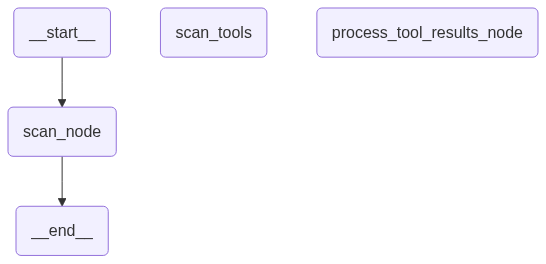

In [3]:
from scan_agent.graph import create_scan_graph
from IPython.display import Image, display

graph = create_scan_graph()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
from langchain_core.runnables.config import RunnableConfig
from agent_core.graph import run_graph
from agent_core.state import ReActUsage, ToolsUsage, Tools, Target
from agent_core.tool import CURL_TOOL, FFUF_TOOL
import uuid
from datetime import timedelta

state = {
    "target": Target(url="http://localhost:8000", description="Local REST API target", type="web"),
    "usage": ReActUsage(limit=25),
    "tools_usage": ToolsUsage(
        limits={
            FFUF_TOOL.name: 2,
            CURL_TOOL.name: 5,
        }
    ),
    "tools": Tools(tools=[FFUF_TOOL, CURL_TOOL]),
}
thread_id = str(uuid.uuid4())[:8]
config = RunnableConfig(
    max_concurrency=10,
    recursion_limit=25,
    configurable={"thread_id": thread_id},
)

print(f"🚀 Starting improved event processing with thread ID: {thread_id}")
print("=" * 80)

event = await run_graph(graph, state, config)